<a href="https://colab.research.google.com/github/mancudEOM/Ensemble-deep-learning/blob/main/model_5fold_DenseNet121_16e3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
  from google.colab import drive
  drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
  !ls


drive  sample_data


In [3]:
  import sys
  root_path = '/content/drive/My Drive/Mulberry Leaf Dataset/' # This is the path to where in google drive the code is stored!
  sys.path.append(root_path)

# THÊM TẤT CẢ CÁC THƯ VIỆN CẦN THIẾT

In [4]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import warnings
import os
import shutil
from PIL import ImageFile
warnings.simplefilter('error', Image.DecompressionBombWarning)
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 1000000000
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Khởi tạo các biến cần thiết

In [5]:
datasetFolderName=root_path+'dataset'
MODEL_FILENAME=root_path+"model_cv.h5"
sourceFiles=[]
classLabels=['01 ChiangMai60','02 RedKing','03 WhiteKing',
             '04 BlackOodTurkey','05 TaiwanStraberry','06 BlackAustralia',
             '07 Buriram60','08 Kamphaengsaeng42','09 TaiwanMeacho','10 ChiangMaiBuriram60']
X=[]
Y=[]

img_rows, img_cols =  224, 224
# input image dimensions
#img_rows, img_cols =  224, 224 # input image dimensions
train_path=datasetFolderName+'/train/'
validation_path=datasetFolderName+'/validation/'
test_path=datasetFolderName+'/test/'

# KFOLD train-test-validation

In [6]:
def transferBetweenFolders(source, dest, splitRate):
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")

def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in classLabels:
        transferBetweenFolders(datasetFolderName+'/'+source+'/'+label+'/',
                               datasetFolderName+'/'+dest+'/'+label+'/',
                               splitRate)

In [7]:
transferAllClassBetweenFolders('test', 'train', 1.0)

In [8]:
transferAllClassBetweenFolders('validation', 'train', 1.0)

In [9]:
transferAllClassBetweenFolders('train', 'test', 0.20)

In [10]:
def prepareNameWithLabels(folderName):
    sourceFiles=os.listdir(datasetFolderName+'/train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        for i in range(len(classLabels)):
          if(folderName==classLabels[i]):
              Y.append(i)

In [11]:
# Organize file names and class labels in X and Y variables
for i in range(len(classLabels)):
  prepareNameWithLabels(classLabels[i])

In [12]:
X=np.asarray(X)
Y=np.asarray(Y)

In [13]:
print(X)
print(Y)

['20191207_134315.jpg' '20191207_135618.jpg' 'IMG_20191207_133413.jpg' ...
 'DSC_0217.JPG' 'DSC_0029.JPG' 'DSC_0363.JPG']
[0 0 0 ... 9 9 9]


In [14]:
batch_size = 16
IMG_SIZE = (224, 224, 3)
number_of_class_labels = len(classLabels)

In [15]:
import tensorflow.keras as keras

In [16]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential(
    [
        keras.layers.Rescaling(1./ 255),
        keras.layers.RandomFlip(),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomZoom(0.2,0.3)
    ]
)

In [17]:
#ResNet50V2 layers except for the last global average pooling and final dense layer.
#pre_trained_layers = keras.applications.ResNet50V2(weights="imagenet", include_top=False,
 #          input_tensor=keras.Input(shape=IMG_SIZE))

In [18]:

pre_trained_layers = keras.applications.DenseNet121(weights="imagenet", include_top=False,
         input_tensor=keras.Input(shape=IMG_SIZE))

29084464/29084464 [==============================] - 2s 0us/step


In [19]:
#pre_trained_layers = tf.keras.applications.ResNet152(weights="imagenet", include_top=False,
#          input_tensor=keras.Input(shape=IMG_SIZE))

In [20]:
pre_trained_layers.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [21]:
#Creating custom model
model = keras.Sequential([
    data_augmentation,                                                    # data augmentations
    pre_trained_layers,                                                   # ResNet pre-trained layers
    keras.layers.GlobalAveragePooling2D(),                                # Adding Global average Pooling 2d
    tf.keras.layers.Dropout(0.3),
    keras.layers.Dense(number_of_class_labels, activation='softmax', name='output')  # Final Dense Layer with 30 neurons
])

In [22]:
EPOCHS = 5
LR = 1e-3
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [23]:
#printing summary of custom model
model.build((1,224,224,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 224, 224, 3)          0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (1, 1024)                0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (1, 1024)                 0         
                                                                 
 output (Dense)              (1, 10)                   10250     
                                                                 
Total params: 7,047,754
Trainable params: 6,964,106
Non-trainable params: 83,648
_______________________________________

In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [25]:
# Callback -> Reduce Learning Rate on Plateau
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto',
                             min_delta=0.0001, cooldown=0, min_lr=0.00001)

In [26]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(X, Y)
fold_num = 0
for train_index, val_index in skf.split(X, Y):
    # First cut all images from validation to train (if any exists)
    transferAllClassBetweenFolders('validation', 'train', 1.0)
    fold_num += 1
    print("Results for fold", fold_num)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    # Move validation images of this fold from train folder to the validation folder
    for each_index in range(len(X_val)):
        class_label = ''
        for i in range(len(classLabels)):
            if(Y_val[each_index] == i):
                class_label = classLabels[i]
        # Then, copy the validation images to the validation folder
        shutil.move(os.path.join(datasetFolderName, 'train', class_label, X_val[each_index]),
                    os.path.join(datasetFolderName, 'validation', class_label, X_val[each_index]))



    # Start ImageClassification Model
    #creating train data set

    train_generator = tf.keras.utils.image_dataset_from_directory(
        train_path,
        image_size=(IMG_SIZE[0], IMG_SIZE[1]),
        batch_size=batch_size,
        )

    validation_generator = tf.keras.utils.image_dataset_from_directory(
        validation_path,
        image_size=(IMG_SIZE[0], IMG_SIZE[1]),
        batch_size=batch_size,

          # only data, no labels
        shuffle=False
        )

    history = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, callbacks=callback)
    model.evaluate(validation_generator)

No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
Results for fold 1
Found 3368 files belonging to 10 classes.
Found 843 files belonging to 10 classes.
Epoch 1/5
211/211 [==============================] - 1033s 4s/step - loss: 1.4555 - accuracy: 0.5053 - val_loss: 3.3985 - val_accuracy: 0.3630 - lr: 0.0010
Epoch 2/5
211/211 [==============================] - 48s 223ms/step - loss: 0.9402 - accuracy: 0.6790 - val_loss: 4.5617 - val_accuracy: 0.4033 - lr: 0.0010
Epoch 3/5
211/211 [==============================] - 55s 256ms/step - loss: 0.7157 - accuracy: 0.7643 - val_loss: 1.9332 - val_accuracy: 0.5860 - lr: 0.0010
Epoch 4/5
211/211 [==============================] - 49s 228ms/step - loss: 0.6032 - accuracy: 0.7936 - val_loss: 1.5426 - val_accuracy: 0

In [27]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

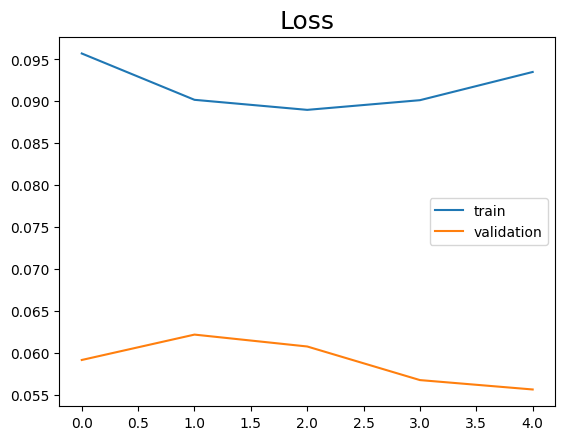

In [28]:
plt.title("Loss", fontdict={'fontsize':18})
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()

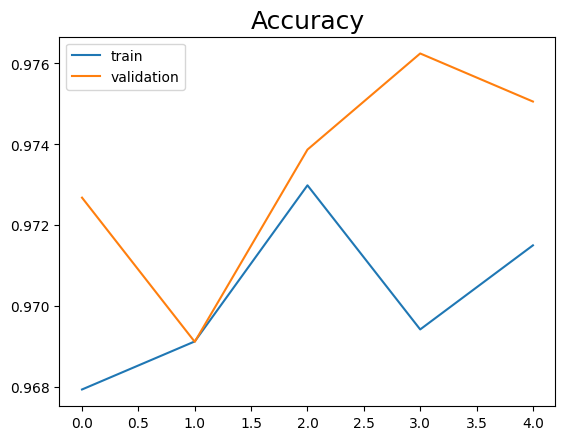

In [29]:
plt.title("Accuracy", fontdict={'fontsize':18})
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='validation')
plt.legend()
plt.show()

In [30]:
Y_train = []
X_train = []
for data in train_generator:
    X_train.extend(data[0].numpy())
    Y_train.extend(data[1].numpy())
Y_train = np.array(Y_train)
X_train = np.array(X_train)

In [31]:
y_train_pred_prob = model.predict(X_train)
y_train_pred = [np.argmax(i) for i in y_train_pred_prob]

106/106 [==============================] - 13s 89ms/step


In [32]:
y_train_pred_prob.shape

(3369, 10)

In [33]:
#function to plot roc-auc curve
def roc_auc_curve(y_scores, y_true):
    # One hot encode the labels in order to plot them
    y_onehot = pd.get_dummies(y_true, columns=classLabels)

    # Create an empty figure, and iteratively add new lines
    # every time we compute a new class
    fig = go.Figure()
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    for i in range(y_scores.shape[1]):
        y_true = y_onehot.iloc[:, i]
        y_score = y_scores[:, i]

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_score = roc_auc_score(y_true, y_score)

        name = f"{classLabels[i]} (AUC={auc_score:.2f})"
        fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

    fig.update_layout(
        title="ROC Curve",
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        yaxis=dict(scaleanchor="x", scaleratio=1),
        xaxis=dict(constrain='domain'),
        width=900, height=800
    )

    return fig

In [34]:
import seaborn as sb

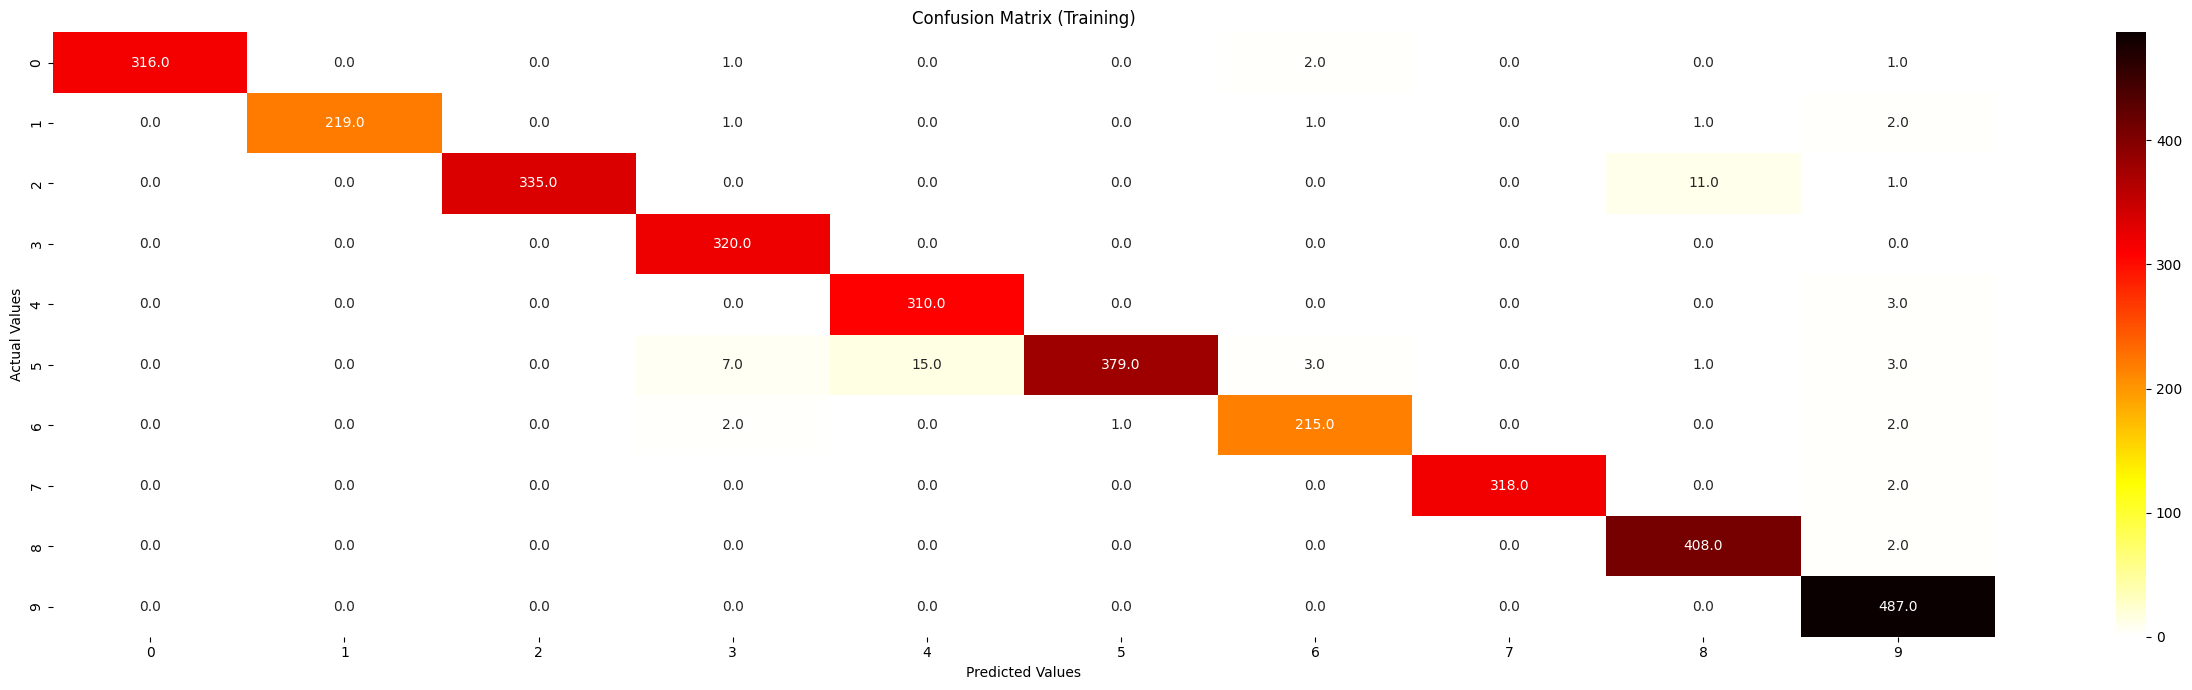

In [35]:
plt.figure(figsize=(25,7))
sb.heatmap(tf.math.confusion_matrix(labels=Y_train,predictions=y_train_pred),annot=True,fmt='.1f', cmap='hot_r')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix (Training)')
plt.tight_layout()
plt.show()

In [36]:
print("Classification Report for Training")
print(classification_report(Y_train, y_train_pred))

Classification Report for Training
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       320
           1       1.00      0.98      0.99       224
           2       1.00      0.97      0.98       347
           3       0.97      1.00      0.98       320
           4       0.95      0.99      0.97       313
           5       1.00      0.93      0.96       408
           6       0.97      0.98      0.98       220
           7       1.00      0.99      1.00       320
           8       0.97      1.00      0.98       410
           9       0.97      1.00      0.98       487

    accuracy                           0.98      3369
   macro avg       0.98      0.98      0.98      3369
weighted avg       0.98      0.98      0.98      3369



In [37]:
roc_auc_curve(y_train_pred_prob, Y_train)
X_test = []
y_test = []
test_generator = tf.keras.utils.image_dataset_from_directory(
        test_path,
        image_size=(IMG_SIZE[0], IMG_SIZE[1]),
        batch_size=batch_size,

          # only data, no labels
        #shuffle=False
        )
for data in test_generator:
    X_test.extend(data[0].numpy())
    y_test.extend(data[1].numpy())
X_test = np.array(X_test)
y_test = np.array(y_test)

Found 1051 files belonging to 10 classes.


In [38]:
y_test_pred_prob = model.predict(X_test)
y_test_pred = [np.argmax(i) for i in y_test_pred_prob]

33/33 [==============================] - 5s 150ms/step


In [39]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

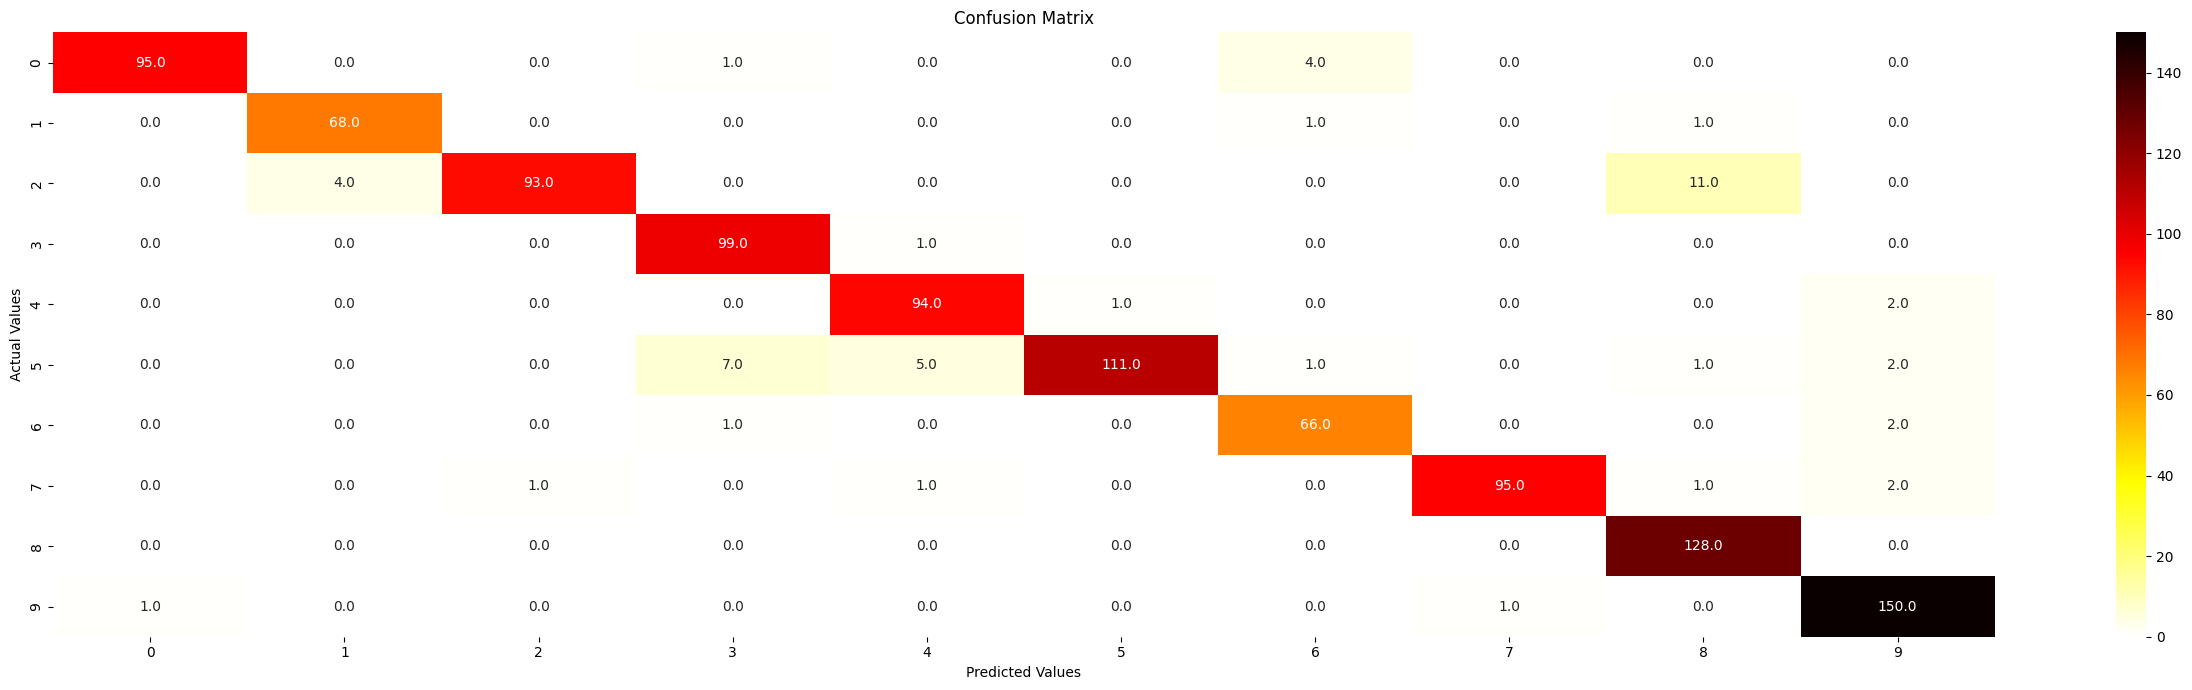

In [40]:
plt.figure(figsize=(25,7))
sb.heatmap(tf.math.confusion_matrix(labels=y_test,predictions=y_test_pred),annot=True,fmt='.1f', cmap='hot_r')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [41]:
print("Classification Report for Test")
print(classification_report(y_test, y_test_pred))

Classification Report for Test
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       100
           1       0.94      0.97      0.96        70
           2       0.99      0.86      0.92       108
           3       0.92      0.99      0.95       100
           4       0.93      0.97      0.95        97
           5       0.99      0.87      0.93       127
           6       0.92      0.96      0.94        69
           7       0.99      0.95      0.97       100
           8       0.90      1.00      0.95       128
           9       0.95      0.99      0.97       152

    accuracy                           0.95      1051
   macro avg       0.95      0.95      0.95      1051
weighted avg       0.95      0.95      0.95      1051



In [42]:
roc_auc_curve(y_test_pred_prob, y_test)

In [43]:
from tensorflow.keras.models import save_model


In [44]:
MODEL_FILENAMEs=root_path+"model_5fold_DenseNet121_16e3.h5"
model.save(MODEL_FILENAMEs)